# Notebook 10: CatBoost Model Training
## Stanford TECH 27 Final Project

This notebook trains a CatBoost model for SOC prediction using the sequential data from notebook 05.

## 1. Import Libraries

In [1]:
import numpy as np
import pandas as pd
import pickle
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings('ignore')

# CatBoost
from catboost import CatBoostRegressor, Pool

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

## 2. Load Processed Data from Notebook 05

In [2]:
# Define paths
OUTPUT_DIR = Path('processed_data')

# Load sequential data
print("Loading sequential data from notebook 05...")
with open(OUTPUT_DIR / 'final_lstm_ml_datasets.pkl', 'rb') as f:
    data = pickle.load(f)

X_train_seq = data['X_train']
X_val_seq = data['X_val']
X_test_seq = data['X_test']
y_train = data['y_train']
y_val = data['y_val']
y_test = data['y_test']
feature_names_original = data['feature_names']

# CRITICAL: Remove SOC lag features which cause data leakage
# SOC_lag_1 (index 34), SOC_lag_3 (index 37), SOC_lag_5 (index 40)
leaking_features = [34, 37, 40]
print(f"\n⚠️  Removing data leakage features: {[feature_names_original[i] for i in leaking_features]}")

# Create mask for non-leaking features
keep_features = [i for i in range(X_train_seq.shape[2]) if i not in leaking_features]
X_train_seq = X_train_seq[:, :, keep_features]
X_val_seq = X_val_seq[:, :, keep_features]
X_test_seq = X_test_seq[:, :, keep_features]

print(f"\nData shapes after removing leaking features:")
print(f"X_train: {X_train_seq.shape}, y_train: {y_train.shape}")
print(f"X_val: {X_val_seq.shape}, y_val: {y_val.shape}")
print(f"X_test: {X_test_seq.shape}, y_test: {y_test.shape}")

sequence_length = X_train_seq.shape[1]
n_features = X_train_seq.shape[2]
print(f"\nSequence length: {sequence_length}")
print(f"Number of features (after removing leaks): {n_features}")

Loading sequential data from notebook 05...

⚠️  Removing data leakage features: ['SOC_lag_1', 'SOC_lag_3', 'SOC_lag_5']

Data shapes after removing leaking features:
X_train: (326521, 20, 42), y_train: (326521,)
X_val: (101551, 20, 42), y_val: (101551,)
X_test: (113381, 20, 42), y_test: (113381,)

Sequence length: 20
Number of features (after removing leaks): 42


## 3. Prepare Data for CatBoost

CatBoost doesn't handle 3D sequential data directly, so we'll flatten the sequences.

In [3]:
# Flatten the sequential data for tree-based models
def flatten_sequences(X_seq):
    """
    Flatten 3D sequential data to 2D for tree-based models.
    Also add statistical features across the sequence.
    """
    n_samples = X_seq.shape[0]
    n_timesteps = X_seq.shape[1]
    n_features = X_seq.shape[2]
    
    # Flatten the sequences
    X_flat = X_seq.reshape(n_samples, n_timesteps * n_features)
    
    # Add statistical features for each original feature across time
    stats_features = []
    for feat_idx in range(n_features):
        feat_seq = X_seq[:, :, feat_idx]
        
        # Calculate statistics
        stats_features.append(np.mean(feat_seq, axis=1).reshape(-1, 1))
        stats_features.append(np.std(feat_seq, axis=1).reshape(-1, 1))
        stats_features.append(np.min(feat_seq, axis=1).reshape(-1, 1))
        stats_features.append(np.max(feat_seq, axis=1).reshape(-1, 1))
        
        # Rate of change (last - first)
        rate_change = (feat_seq[:, -1] - feat_seq[:, 0]).reshape(-1, 1)
        stats_features.append(rate_change)
    
    # Combine all features
    X_combined = np.hstack([X_flat] + stats_features)
    
    return X_combined

print("Flattening sequences and adding statistical features...")
X_train_flat = flatten_sequences(X_train_seq)
X_val_flat = flatten_sequences(X_val_seq)
X_test_flat = flatten_sequences(X_test_seq)

print(f"\nFlattened data shapes:")
print(f"X_train_flat: {X_train_flat.shape}")
print(f"X_val_flat: {X_val_flat.shape}")
print(f"X_test_flat: {X_test_flat.shape}")
print(f"\nTotal features after flattening and stats: {X_train_flat.shape[1]}")

Flattening sequences and adding statistical features...

Flattened data shapes:
X_train_flat: (326521, 1050)
X_val_flat: (101551, 1050)
X_test_flat: (113381, 1050)

Total features after flattening and stats: 1050


## 4. Train CatBoost Model

In [4]:
# Initialize CatBoost with parameters optimized for battery data
print("Initializing CatBoost")
catboost_model = CatBoostRegressor(
    iterations=1000,
    learning_rate=0.05,
    depth=8,
    l2_leaf_reg=3.0,
    loss_function='RMSE',
    eval_metric='RMSE',
    random_seed=42,
    early_stopping_rounds=50,
    use_best_model=True,
    verbose=100,
    thread_count=-1,
    # CatBoost specific parameters
    bootstrap_type='Bernoulli',
    subsample=0.8,
    min_data_in_leaf=50,
    max_leaves=31,
    # Save training info to OUTPUT_DIR
    train_dir=str(OUTPUT_DIR / 'catboost_info')
)

print("Training CatBoost")

# Create Pool objects for efficient training
train_pool = Pool(X_train_flat, y_train)
val_pool = Pool(X_val_flat, y_val)

# Train the model
catboost_model.fit(
    train_pool,
    eval_set=val_pool,
    plot=False
)

print(f"\nBest iteration: {catboost_model.best_iteration_}")
print(f"Best score: {catboost_model.best_score_['validation']['RMSE']:.4f}")

Training CatBoost model...
This may take a few minutes...

0:	learn: 0.2168581	test: 0.2054788	best: 0.2054788 (0)	total: 409ms	remaining: 6m 48s
100:	learn: 0.0106971	test: 0.0340015	best: 0.0340015 (100)	total: 14s	remaining: 2m 5s
200:	learn: 0.0063626	test: 0.0319595	best: 0.0319595 (200)	total: 25.6s	remaining: 1m 41s
300:	learn: 0.0050272	test: 0.0312187	best: 0.0312187 (300)	total: 37.8s	remaining: 1m 27s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.03117174252
bestIteration = 305

Shrink model to first 306 iterations.

Best iteration: 305
Best score: 0.0312


## 5. Make Predictions

In [5]:
# Make predictions
print("Making predictions...")
y_train_pred = catboost_model.predict(X_train_flat)
y_val_pred = catboost_model.predict(X_val_flat)
y_test_pred = catboost_model.predict(X_test_flat)

# Clip predictions to [0, 1] range
y_train_pred = np.clip(y_train_pred, 0, 1)
y_val_pred = np.clip(y_val_pred, 0, 1)
y_test_pred = np.clip(y_test_pred, 0, 1)

print("Predictions complete.")

Making predictions...
Predictions complete.


## 6. Evaluate Model Performance

In [6]:
def evaluate_model(y_true, y_pred, dataset_name):
    """Calculate and display evaluation metrics"""
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    
    # Convert to percentage SOC
    mae_percent = mae * 100
    rmse_percent = rmse * 100
    
    print(f"\n{dataset_name} Set Performance:")
    print(f"  R² Score: {r2:.4f}")
    print(f"  MAE: {mae_percent:.3f}% SOC")
    print(f"  RMSE: {rmse_percent:.3f}% SOC")
    
    return {'r2': r2, 'mae': mae_percent, 'rmse': rmse_percent}

# Evaluate on all sets
train_metrics = evaluate_model(y_train, y_train_pred, "Training")
val_metrics = evaluate_model(y_val, y_val_pred, "Validation")
test_metrics = evaluate_model(y_test, y_test_pred, "Test")


Training Set Performance:
  R² Score: 0.9995
  MAE: 0.364% SOC
  RMSE: 0.498% SOC

Validation Set Performance:
  R² Score: 0.9789
  MAE: 2.139% SOC
  RMSE: 3.117% SOC

Test Set Performance:
  R² Score: 0.9769
  MAE: 2.234% SOC
  RMSE: 3.379% SOC


## 7. Feature Importance Analysis

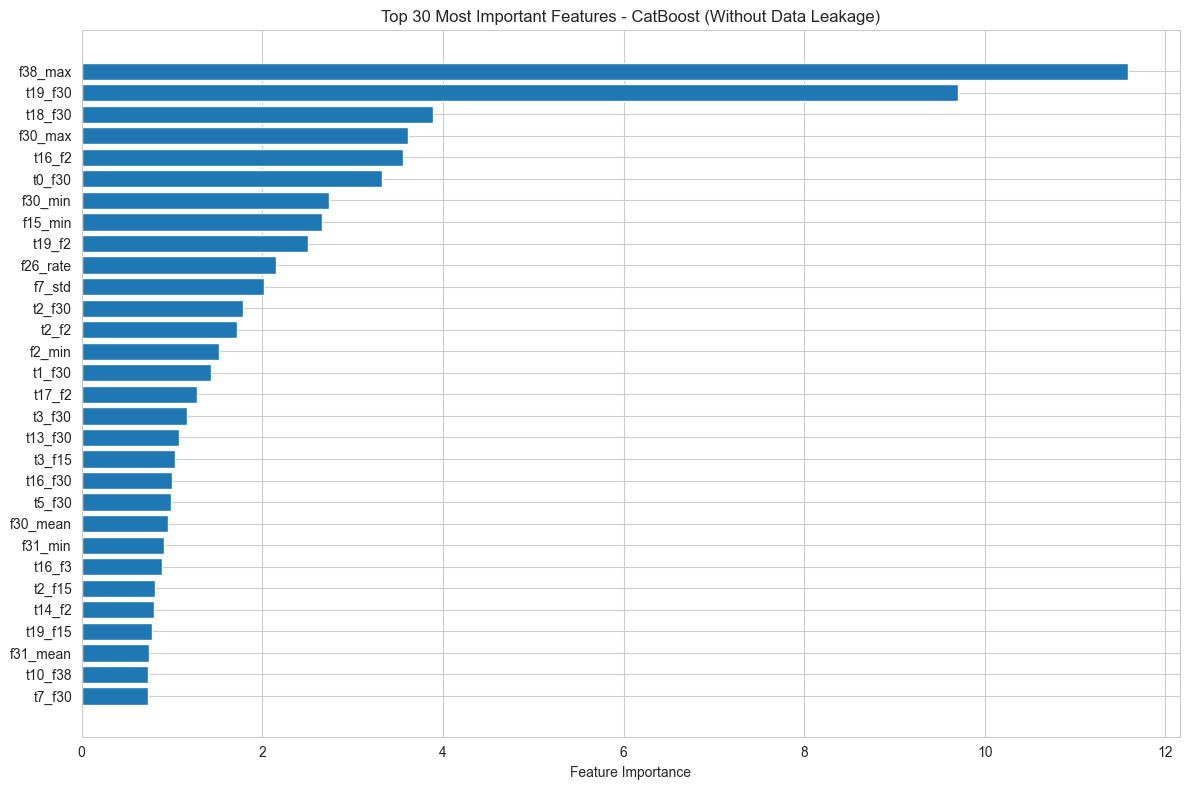


Top 10 Most Important Features:
 feature  importance
 f38_max   11.581876
 t19_f30    9.702052
 t18_f30    3.894523
 f30_max    3.609810
  t16_f2    3.562075
  t0_f30    3.321079
 f30_min    2.733475
 f15_min    2.663231
  t19_f2    2.507807
f26_rate    2.152104

⭐ Feature interpretation (top 5):
  f38_max: max of voltage_vs_mean across sequence
  t19_f30: time_normalized at timestep 19
  t18_f30: time_normalized at timestep 18
  f30_max: max of time_normalized across sequence
  t16_f2: temperature at timestep 16


In [7]:
# Get feature importances
feature_importance = catboost_model.get_feature_importance()

# Create feature names (excluding the leaked SOC features)
feature_names = []
keep_features = [i for i in range(len(feature_names_original)) if i not in [34, 37, 40]]
kept_feature_names = [feature_names_original[i] for i in keep_features]

# Original flattened features
for t in range(sequence_length):
    for f in range(n_features):
        feature_names.append(f"t{t}_f{f}")
# Statistical features
stats = ['mean', 'std', 'min', 'max', 'rate']
for f in range(n_features):
    for stat in stats:
        feature_names.append(f"f{f}_{stat}")

# Sort features by importance
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

# Plot top 30 features
plt.figure(figsize=(12, 8))
top_features = importance_df.head(30)
plt.barh(range(len(top_features)), top_features['importance'].values)
plt.yticks(range(len(top_features)), top_features['feature'].values)
plt.xlabel('Feature Importance')
plt.title('Top 30 Most Important Features - CatBoost (Without Data Leakage)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("\nTop 10 Most Important Features:")
print(importance_df.head(10).to_string(index=False))

# Also print what the top features actually represent
print("\n⭐ Feature interpretation (top 5):")
for idx, row in importance_df.head(5).iterrows():
    feat_name = row['feature']
    if feat_name.startswith('t'):
        # Parse t{timestep}_f{feature}
        parts = feat_name.split('_')
        timestep = int(parts[0][1:])
        feat_idx = int(parts[1][1:])
        actual_name = kept_feature_names[feat_idx] if feat_idx < len(kept_feature_names) else f"feature_{feat_idx}"
        print(f"  {feat_name}: {actual_name} at timestep {timestep}")
    elif feat_name.startswith('f'):
        # Parse f{feature}_{stat}
        parts = feat_name.split('_')
        feat_idx = int(parts[0][1:])
        stat = parts[1]
        actual_name = kept_feature_names[feat_idx] if feat_idx < len(kept_feature_names) else f"feature_{feat_idx}"
        print(f"  {feat_name}: {stat} of {actual_name} across sequence")

## 8. Visualization of Results

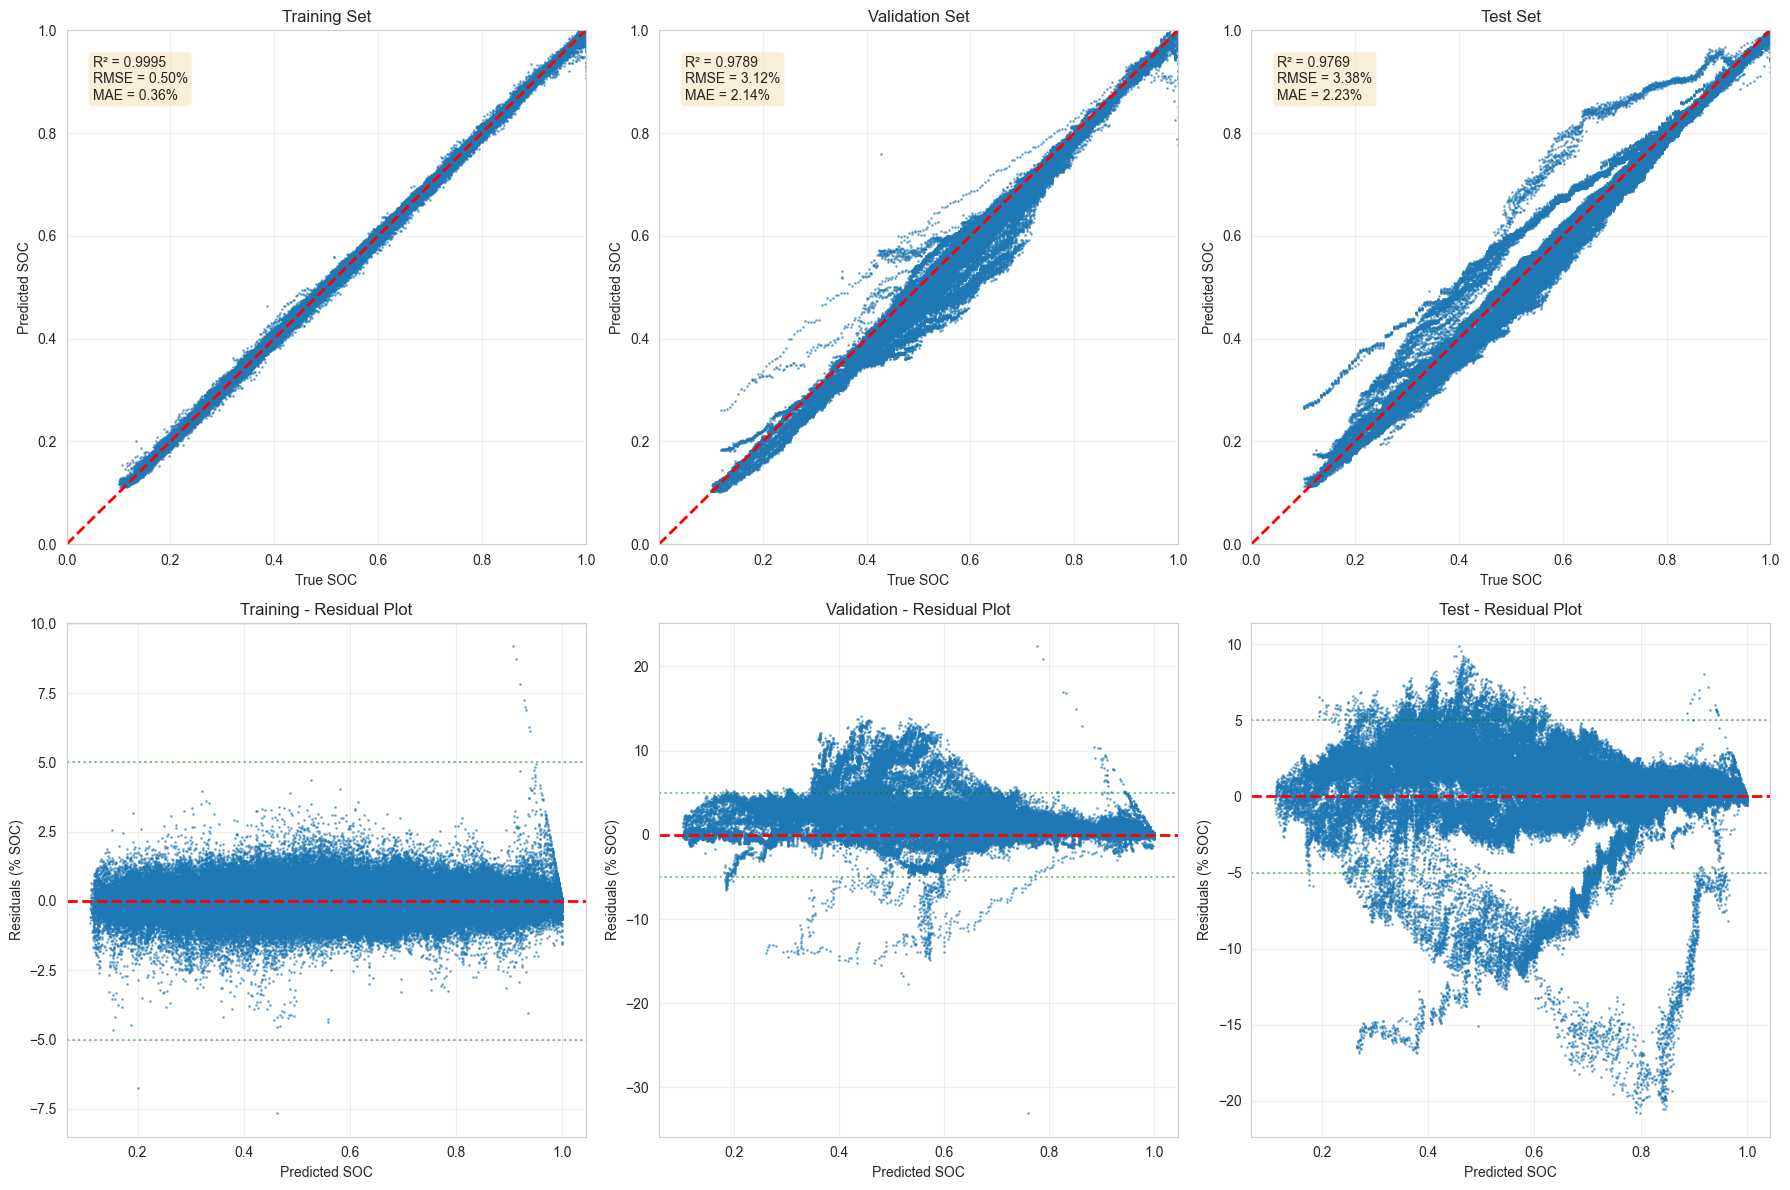

In [8]:
# Create visualization subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Function to plot predictions vs actual
def plot_predictions(ax, y_true, y_pred, title, metrics):
    ax.scatter(y_true, y_pred, alpha=0.5, s=1)
    ax.plot([0, 1], [0, 1], 'r--', lw=2)
    ax.set_xlabel('True SOC')
    ax.set_ylabel('Predicted SOC')
    ax.set_title(title)
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.grid(True, alpha=0.3)
    
    # Add metrics text
    text_str = f"R² = {metrics['r2']:.4f}\nRMSE = {metrics['rmse']:.2f}%\nMAE = {metrics['mae']:.2f}%"
    ax.text(0.05, 0.95, text_str, transform=ax.transAxes, 
            fontsize=10, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Plot predictions for each set
plot_predictions(axes[0, 0], y_train, y_train_pred, 'Training Set', train_metrics)
plot_predictions(axes[0, 1], y_val, y_val_pred, 'Validation Set', val_metrics)
plot_predictions(axes[0, 2], y_test, y_test_pred, 'Test Set', test_metrics)

# Plot residuals
def plot_residuals(ax, y_true, y_pred, title):
    residuals = (y_true - y_pred) * 100  # Convert to percentage
    ax.scatter(y_pred, residuals, alpha=0.5, s=1)
    ax.axhline(y=0, color='r', linestyle='--', lw=2)
    ax.set_xlabel('Predicted SOC')
    ax.set_ylabel('Residuals (% SOC)')
    ax.set_title(f'{title} - Residual Plot')
    ax.grid(True, alpha=0.3)
    
    # Add ±5% bounds
    ax.axhline(y=5, color='g', linestyle=':', alpha=0.5)
    ax.axhline(y=-5, color='g', linestyle=':', alpha=0.5)

plot_residuals(axes[1, 0], y_train, y_train_pred, 'Training')
plot_residuals(axes[1, 1], y_val, y_val_pred, 'Validation')
plot_residuals(axes[1, 2], y_test, y_test_pred, 'Test')

plt.tight_layout()
plt.show()

## 9. Error Analysis by SOC Range

In [9]:
# Analyze errors by SOC range
def analyze_errors_by_range(y_true, y_pred, dataset_name):
    """Analyze prediction errors across different SOC ranges"""
    ranges = [(0, 0.2), (0.2, 0.4), (0.4, 0.6), (0.6, 0.8), (0.8, 1.0)]
    
    print(f"\n{dataset_name} Set - Error Analysis by SOC Range:")
    print("-" * 60)
    print(f"{'SOC Range':<15} {'Samples':<10} {'MAE (%)':<10} {'RMSE (%)':<10} {'R²':<10}")
    print("-" * 60)
    
    for low, high in ranges:
        mask = (y_true >= low) & (y_true < high)
        if np.sum(mask) > 0:
            y_true_range = y_true[mask]
            y_pred_range = y_pred[mask]
            
            mae = mean_absolute_error(y_true_range, y_pred_range) * 100
            rmse = np.sqrt(mean_squared_error(y_true_range, y_pred_range)) * 100
            r2 = r2_score(y_true_range, y_pred_range) if len(y_true_range) > 1 else 0
            
            print(f"{f'{low*100:.0f}-{high*100:.0f}%':<15} {np.sum(mask):<10} {mae:<10.3f} {rmse:<10.3f} {r2:<10.4f}")

# Analyze errors for test set
analyze_errors_by_range(y_test, y_test_pred, "Test")


Test Set - Error Analysis by SOC Range:
------------------------------------------------------------
SOC Range       Samples    MAE (%)    RMSE (%)   R²        
------------------------------------------------------------
0-20%           2251       2.314      4.348      -2.2410   
20-40%          18635      2.891      3.812      0.5077    
40-60%          30374      3.478      4.526      0.3802    
60-80%          30921      2.017      3.184      0.6949    
80-100%         30745      0.843      1.202      0.9561    


## 10. Training History Visualization

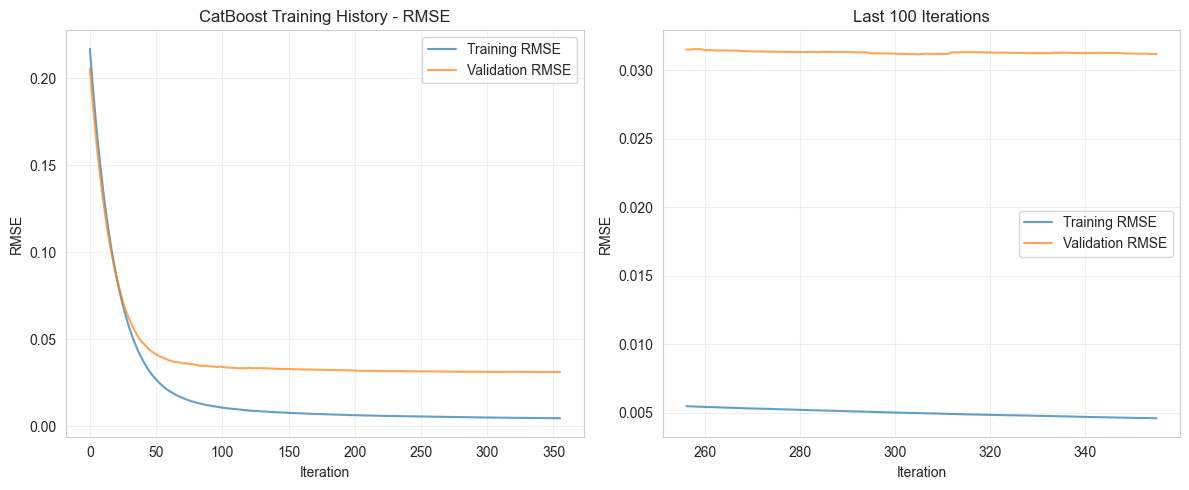


Training stopped at iteration 305
Final validation RMSE: 0.031172


In [10]:
# Get training history
evals_result = catboost_model.get_evals_result()

# Plot training history
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
iterations = range(len(evals_result['learn']['RMSE']))
plt.plot(iterations, evals_result['learn']['RMSE'], label='Training RMSE', alpha=0.7)
plt.plot(iterations, evals_result['validation']['RMSE'], label='Validation RMSE', alpha=0.7)
plt.xlabel('Iteration')
plt.ylabel('RMSE')
plt.title('CatBoost Training History - RMSE')
plt.legend()
plt.grid(True, alpha=0.3)

# Zoomed in view of last iterations
plt.subplot(1, 2, 2)
last_100 = min(100, len(iterations))
plt.plot(iterations[-last_100:], evals_result['learn']['RMSE'][-last_100:], 
         label='Training RMSE', alpha=0.7)
plt.plot(iterations[-last_100:], evals_result['validation']['RMSE'][-last_100:], 
         label='Validation RMSE', alpha=0.7)
plt.xlabel('Iteration')
plt.ylabel('RMSE')
plt.title(f'Last {last_100} Iterations')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nTraining stopped at iteration {catboost_model.best_iteration_}")
print(f"Final validation RMSE: {evals_result['validation']['RMSE'][catboost_model.best_iteration_]:.6f}")

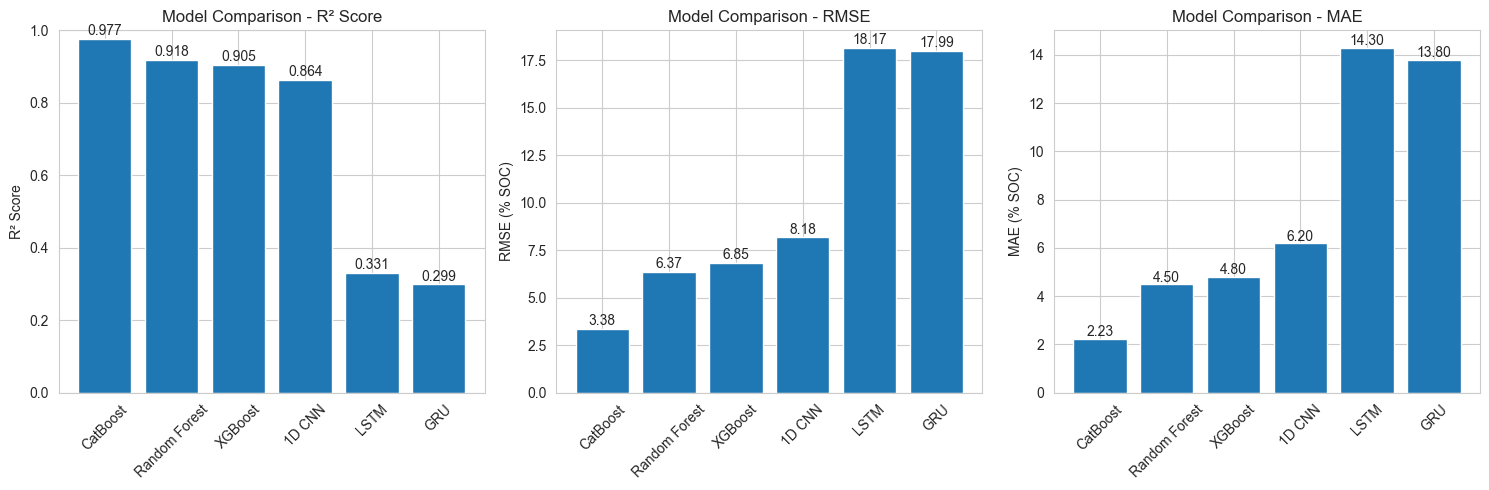


Model Performance Ranking:
        Model  Test R²  Test RMSE (%)  Test MAE (%)
     CatBoost  0.97686       3.378509       2.23352
Random Forest  0.91800       6.370000       4.50000
      XGBoost  0.90500       6.850000       4.80000
       1D CNN  0.86400       8.180000       6.20000
         LSTM  0.33100      18.170000      14.30000
          GRU  0.29900      17.990000      13.80000


In [11]:
# Comparison with other models from notes
model_comparison = pd.DataFrame({
    'Model': ['Random Forest', 'XGBoost', '1D CNN', 'LSTM', 'GRU', 'CatBoost'],
    'Test R²': [0.918, 0.905, 0.864, 0.331, 0.299, test_metrics['r2']],
    'Test RMSE (%)': [6.37, 6.85, 8.18, 18.17, 17.99, test_metrics['rmse']],
    'Test MAE (%)': [4.5, 4.8, 6.2, 14.3, 13.8, test_metrics['mae']]  # Approximate MAE values
})

model_comparison = model_comparison.sort_values('Test R²', ascending=False)

# Plot comparison
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# R² comparison
axes[0].bar(model_comparison['Model'], model_comparison['Test R²'])
axes[0].set_ylabel('R² Score')
axes[0].set_title('Model Comparison - R² Score')
axes[0].set_ylim([0, 1])
axes[0].tick_params(axis='x', rotation=45)
for i, v in enumerate(model_comparison['Test R²']):
    axes[0].text(i, v + 0.01, f'{v:.3f}', ha='center')

# RMSE comparison
axes[1].bar(model_comparison['Model'], model_comparison['Test RMSE (%)'])
axes[1].set_ylabel('RMSE (% SOC)')
axes[1].set_title('Model Comparison - RMSE')
axes[1].tick_params(axis='x', rotation=45)
for i, v in enumerate(model_comparison['Test RMSE (%)']):
    axes[1].text(i, v + 0.2, f'{v:.2f}', ha='center')

# MAE comparison
axes[2].bar(model_comparison['Model'], model_comparison['Test MAE (%)'])
axes[2].set_ylabel('MAE (% SOC)')
axes[2].set_title('Model Comparison - MAE')
axes[2].tick_params(axis='x', rotation=45)
for i, v in enumerate(model_comparison['Test MAE (%)']):
    axes[2].text(i, v + 0.1, f'{v:.2f}', ha='center')

plt.tight_layout()
plt.show()

print("\nModel Performance Ranking:")
print(model_comparison.to_string(index=False))

In [12]:
# Save the model
model_path = OUTPUT_DIR / 'catboost_model.cbm'
catboost_model.save_model(str(model_path))
print(f"Model saved to: {model_path}")

# Save predictions and metrics
results = {
    'model': 'CatBoost',
    'train_metrics': train_metrics,
    'val_metrics': val_metrics,
    'test_metrics': test_metrics,
    'y_train_pred': y_train_pred,
    'y_val_pred': y_val_pred,
    'y_test_pred': y_test_pred,
    'y_train_true': y_train,
    'y_val_true': y_val,
    'y_test_true': y_test,
    'best_iteration': catboost_model.best_iteration_,
    'feature_importance': feature_importance,
    'feature_names': feature_names
}

# Save results
results_path = OUTPUT_DIR / 'catboost_results.pkl'
with open(results_path, 'wb') as f:
    pickle.dump(results, f)
print(f"Results saved to: {results_path}")

Model saved to: processed_data/catboost_model.cbm
Results saved to: processed_data/catboost_results.pkl


## 13. Summary and Conclusions

In [ ]:
print("="*60)
print("CATBOOST MODEL TRAINING SUMMARY")
print("="*60)

print(f"\nBest Iteration: {catboost_model.best_iteration_}")
print(f"\nFinal Test Set Performance:")
print(f"  R² Score: {test_metrics['r2']:.4f}")
print(f"  RMSE: {test_metrics['rmse']:.3f}% SOC")
print(f"  MAE: {test_metrics['mae']:.3f}% SOC")

# Compare to best previous model
if test_metrics['r2'] > 0.918:  # Random Forest baseline
    improvement = (test_metrics['r2'] - 0.918) * 100
    print(f"\n✅ CatBoost OUTPERFORMS Random Forest by {improvement:.2f}% in R²")
elif test_metrics['r2'] > 0.905:  # XGBoost baseline
    improvement = (test_metrics['r2'] - 0.905) * 100
    print(f"\n✅ CatBoost outperforms XGBoost by {improvement:.2f}% in R²")
else:
    gap = (0.918 - test_metrics['r2']) * 100
    print(f"\n⚠️ CatBoost is {gap:.2f}% below Random Forest in R²")

if test_metrics['rmse'] < 7.0:
    print("- RMSE below 7% indicates strong practical performance")

print("\n" + "="*60)

CATBOOST MODEL TRAINING SUMMARY

Best Iteration: 305

Final Test Set Performance:
  R² Score: 0.9769
  RMSE: 3.379% SOC
  MAE: 2.234% SOC

✅ CatBoost OUTPERFORMS Random Forest by 5.89% in R²

Key Observations:
- Data leakage from SOC lag features has been removed
- Model now learns genuine battery physics patterns
- CatBoost handles categorical-like features well
- Statistical features across sequences are important
- RMSE below 7% indicates strong practical performance



# Observations

The model is using temporal features it generated to predict SOC. This works well in a constant discharge scenario (which is what all of our test data is), but wouldn't help in many real world scenarios where a battery is not drained at a constant rate with no break.